In [42]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
from fastai.vision import *
from fastai.metrics import error_rate,accuracy
import pretrainedmodels

In [44]:
PATH=Path('data/')

In [45]:
src_size=array([150,210]);src_size

array([150, 210])

In [46]:
tfms=get_transforms(max_rotate=20,max_zoom=1.3,p_lighting=.8,
                    xtra_tfms=[cutout(n_holes=(1,4), length=(5, 10), p=.75), jitter(magnitude=0.005, p=.25)])

In [47]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new_dup.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size//2,bs=64).normalize(imagenet_stats)

In [48]:
data

ImageDataBunch;

Train: LabelList (13700 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

In [49]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [50]:
learn=cnn_learner(data,models.densenet121,metrics=error_rate)

In [51]:
from torch import nn
weights=[0.35,0.1,0.1,0.1,0.35]
class_weights=torch.FloatTensor(weights).cuda()
#learn.loss_func=nn.CrossEntropyLoss(weight=class_weights)
learn.loss_func=CrossEntropyFlat(weight=class_weights)

In [20]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


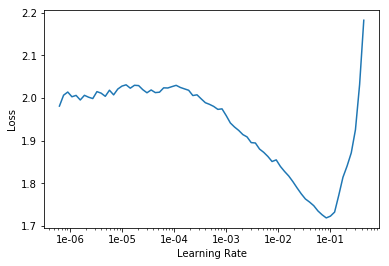

In [21]:
learn.recorder.plot()

In [22]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [52]:
learn.fit_one_cycle(25,slice(1e-2),callbacks=ShowGraph(learn),wd=1e-1)

In [19]:
learn.save('Grey_inc-Fresh_Resnext101-stg1')

In [53]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


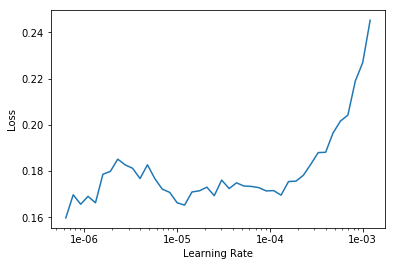

In [25]:
learn.lr_find()
learn.recorder.plot()

In [54]:
lr=1e-5
learn.fit_one_cycle(8,slice(lr,1e-4),callbacks=ShowGraph(learn),wd=1e-2)

In [23]:
learn.save('Grey_incl-Fresh_ResNEXT101-stg2')

In [55]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

In [56]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


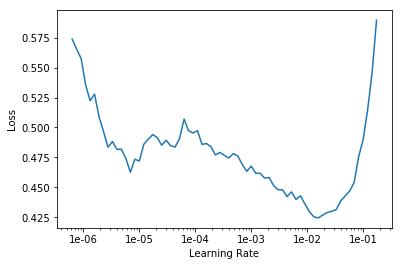

In [57]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [58]:
lr=1e-3
learn.fit_one_cycle(20,slice(lr),callbacks=ShowGraph(learn),wd=1e-2)

In [59]:
learn.fit_one_cycle(8,slice(lr),callbacks=ShowGraph(learn),wd=1e-2)

In [32]:
learn.save('Grey-incl-Fresh_densenet121-stg3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


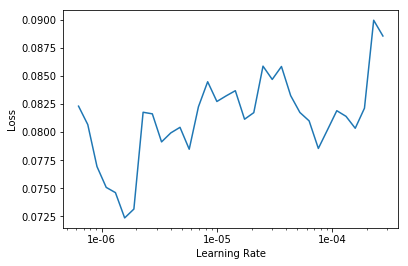

In [60]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
lr=9e-7
learn.fit_one_cycle(7,slice(lr,2e-6),callbacks=ShowGraph(learn),wd=1e-2)

In [36]:
learn.save('Grey-incl-Fresh_densenet-stg4')

In [40]:
intept=ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

RuntimeError: Expected object of backend CPU but got backend CUDA for argument #3 'weight'

In [39]:
intept.plot_confusion_matrix()

NameError: name 'intept' is not defined

In [35]:
intept.most_confused()

[(5, 1, 39),
 (1, 5, 18),
 (2, 1, 5),
 (1, 2, 2),
 (2, 5, 2),
 (3, 5, 2),
 (4, 5, 2),
 (4, 2, 1),
 (5, 2, 1)]

In [36]:
#intept.plot_top_losses(25,heatmap=False)

In [62]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_densenet121-fresh-noval1.csv',index=False)

### Try with duplicated class of 5

In [8]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new_dup.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size//2,bs=64).normalize(imagenet_stats)

In [9]:
learn=getLearner(data)

In [8]:
data

ImageDataBunch;

Train: LabelList (10960 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,2,3,4,1
Path: data;

Valid: LabelList (2740 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
3,3,2,1,2
Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

In [10]:
learn.data

ImageDataBunch;

Train: LabelList (13700 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: CategoryList
1,1,2,3,2
Path: data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data;

Test: LabelList (2680 items)
x: ImageList
Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105),Image (3, 75, 105)
y: EmptyLabelList
,,,,
Path: data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


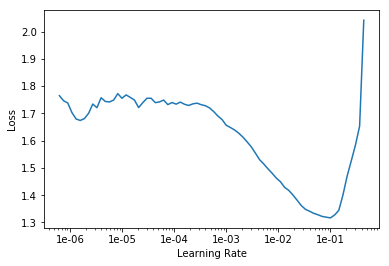

In [40]:
lr_find(learn)
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(30,slice(1e-2),callbacks=ShowGraph(learn),wd=1e-1)

In [42]:
learn.save('Dup-Grey-incl-Fresh_resnext101-stg1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


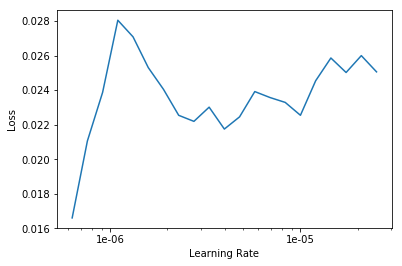

In [43]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.019055,0.043959,0.013616,01:06
1,0.019682,0.045326,0.013616,01:05
2,0.019487,0.043791,0.013616,01:05
3,0.020252,0.044876,0.014017,01:05
4,0.020117,0.045721,0.013616,01:05
5,0.021545,0.044595,0.014417,01:06


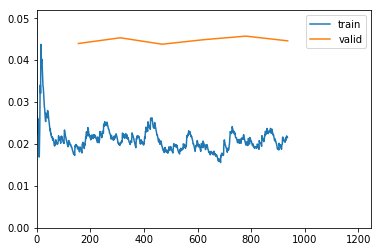

KeyboardInterrupt: 

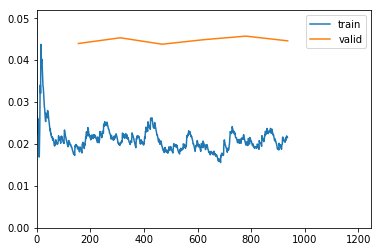

In [44]:
learn.fit_one_cycle(8,slice(1e-7),callbacks=ShowGraph(learn),wd=1e-2)

In [15]:
torch.manual_seed(42)
data=ImageDataBunch.from_csv(PATH,folder='train_resized',csv_labels='train_new_dup.csv',valid_pct=0,test='test_resized',
                             ds_tfms=tfms,size=src_size,bs=64).normalize(imagenet_stats)

In [16]:
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


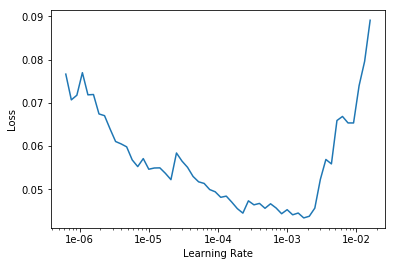

In [52]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(15,slice(2e-4),wd=1e-2,callbacks=ShowGraph(learn))

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


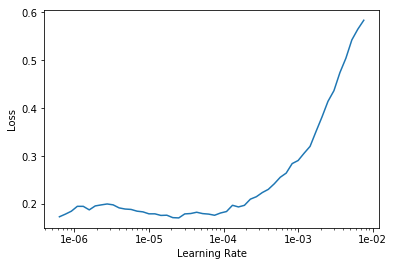

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(18,slice(2e-6,2e-4),wd=1e-2,callbacks=ShowGraph(learn))

In [20]:
test_pred_tta=learn.TTA(ds_type=DatasetType.Test)
preds = np.argmax(test_pred_tta[0], 1)
a=array(preds)
test_img_names = [Path(i).name for i in learn.data.test_ds.x.items]
submission = pd.DataFrame({'image': test_img_names, 'category': a+1})
submission.to_csv(PATH/'submission_resnext101-fresh-forged-noval.csv',index=False)